#Summary

**Models**

I trained two models for image segmentation on the roof data set.

Even though it is a rather too complex a model for this task, I first trained a mask R-CNN instance segmentation model ([pytorch maskrcnn_resnet50_fpn model](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html) pretrained on the [COCO dataset](https://cocodataset.org/#home)  |  [mask R-CNN paper](https://arxiv.org/pdf/1703.06870.pdf)). This model does not do a direct segmentation of the binary classification problem (non-roof/roof) of each pixel in an image, but detects objects and performs the segmentation task only in the proposed bounding boxes (where also the prediction on the class is done).

As a second model, I trained a U-net model (from the scratch | [U-net model](https://arxiv.org/pdf/1505.04597.pdf)) that also does pixelwise classification of background or roof, but on the whole image at once.




**Optimization**

I trained both models for 100 epochs.

For the mask R-CNN model, I used the predefined total loss as a minimization criterion, which includes bounding box, mask (binary cross entropy), and classification losses. The parameters for a step learning rate scheduler and for data augmentation of training data were tuned accordingly.

For the U-net model, binary cross-entropy loss yielded the best results in terms the least IoU and F1 scores. Based on some experiments, I found a well working network architecture (3 convolutional blocks each for encoder and decoder) and adjusted the learning rates for a cosine annealing scheduler.

**Results**

The mask R-CNN model provided close predictions to the true masks. Unlike the U-net predictions, the outlines of the roof tops on the test images are reproduced quite precisely. Considering only proposed objects with an IoU of 0.5 or higher, the mask R-CNN achieved an average over instances F1 score of 0.84 (evaluated on the training data as I don't have the true masks for the 5 test images). However, the mask detection of possible regions of objects was not optimally tuned. A lot of roof tops are detected multiple times, and often together other buildings. The segmentation results could be improved if one would implement filtering of detected objects by a minimal IoU threshold or some way tune the object detection / bounding box regression of the model better.

The U-net model achieved a F1 score of 0.94 on the training data, which is higher than that of the mask R-CNN model, although its predictions for roof shapes seem not as accurate. However, the two F1 scores of the mask R-CNN and U-net model are not directly comparable due to the different evaluation regions: only within accepted bounding boxes for the mask R-CNN and the entire image for U-net which relatively include more background pixel.

---
---
---

#Setup

##General definitions and imports

In [1]:
# folder git repo was cloned to and that contains this script
git_dir = 'roof_segmentation'

In [2]:
import os
from pathlib import Path
from copy import deepcopy as dc
import pickle
from google.colab import drive

from PIL import Image
import cv2
from matplotlib import pyplot as plt
import torch
import numpy as np
import pandas as pd

In [3]:
def plot_row(**images):

    if 'fontsize' in images.keys():
      fontsize = list(images.items())[list(images.keys()).index('fontsize')][1]
      del images['fontsize']
    else: fontsize = 10

    if 'imagesize' in images.keys():
      imagesize = list(images.items())[list(images.keys()).index('imagesize')][1]
      del images['imagesize']
    else: imagesize = 3

    if 'cmap' in images.keys():
      cmap = list(images.items())[list(images.keys()).index('cmap')][1]
      del images['cmap']
    else: cmap = None

    if 'vmin' in images.keys():
      vmin = list(images.items())[list(images.keys()).index('vmin')][1]
      del images['vmin']
    else: vmin = 0

    if 'vmax' in images.keys():
      vmax = list(images.items())[list(images.keys()).index('vmax')][1]
      del images['vmax']
    else: vmax = 255

    n_images = len(images)
    plt.figure(figsize=(imagesize*n_images,imagesize))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=fontsize)
        if isinstance(cmap, type(None)):
          plt.imshow(image)
        else:
          plt.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.show()

def update_device():
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  return device

In [ ]:
color_palette = [# background
                 0,0,0,
                 # 1st, 2nd, ... instance detected
                 141, 211, 199,
                 255,255,179,
                 190,186,218,
                 251,128,114,
                 128,177,211,
                 253,180,98,
                 179,222,105,
                 252,205,229,
                 217,217,217,
                 188,128,189,
                 204,235,197,
                 255,237,111]

---

##Create project folder



**Clone Project folder**

In [4]:
drive.mount('my-drive')

Mounted at my-drive


In [5]:
base_dir = '/content/my-drive/MyDrive/'
proj_dir = f'{base_dir}/Projects/{git_dir}'
%cd $proj_dir
!ls -lah

/content/my-drive/MyDrive/Projects/roof_segmentation
total 5.2M
drwx------ 2 root root 4.0K Jun 23 07:01 data
drwx------ 2 root root 4.0K Jun 23 15:37 .git
-rw------- 1 root root   35 Jun 23 15:20 .gitignore
drwx------ 2 root root 4.0K Jun 23 07:01 models
drwx------ 2 root root 4.0K Jun 23 07:01 predicted
-rw------- 1 root root 5.2M Jun 23 15:45 roof_segmentation.ipynb


---

**Test if GPU is enabled**

In [6]:
torch.cuda.is_available()

True

---
---
---

#Preparation of Data

##Download data

In [ ]:
%cd data

!wget https://cdn.dida.do/downloads/dida-test-task/dida_test_task.zip
!unzip -d original/ dida_test_task.zip
!rm -rf original/__MACOSX ./dida_test_task.zip
!ls -lah original|

--2023-06-23 07:20:16--  https://cdn.dida.do/downloads/dida-test-task/dida_test_task.zip
Resolving cdn.dida.do (cdn.dida.do)... 205.185.216.10, 205.185.216.42
Connecting to cdn.dida.do (cdn.dida.do)|205.185.216.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4768056 (4.5M) [application/zip]
Saving to: ‘dida_test_task.zip’

dida_test_task.zip  100%[===================>]   4.55M  6.68MB/s    in 0.7s    

2023-06-23 07:20:17 (6.68 MB/s) - ‘dida_test_task.zip’ saved [4768056/4768056]

Archive:  dida_test_task.zip
   creating: original/images/
  inflating: original/images/121.png  
   creating: original/__MACOSX/
   creating: original/__MACOSX/images/
  inflating: original/__MACOSX/images/._121.png  
  inflating: original/images/241.png  
  inflating: original/__MACOSX/images/._241.png  
  inflating: original/images/270.png  
  inflating: original/__MACOSX/images/._270.png  
  inflating: original/images/272.png  
  inflating: original/__MACOSX/images/._272.png  

##Check Images and Labels are correct

In [ ]:
for file in sorted(os.listdir('original/images')):
  print('\nFile:', file)

  image = Image.open(f'original/images/{file}')
  if os.path.exists(f'original/labels/{file}'):
    label = Image.open(f'original/labels/{file}')
    print(len(np.unique(np.array(label))), 'different colors in label.')
  else:
    label = np.zeros(np.array(image).shape)

  plot_row(image=image, label=label)

Output hidden; open in https://colab.research.google.com to view.


*   Image 278.png has a wrong label (the same as 270.png).
*   Therefore, I created a new mask for 278.png in Gimp, to not lose one of the rare training samples.




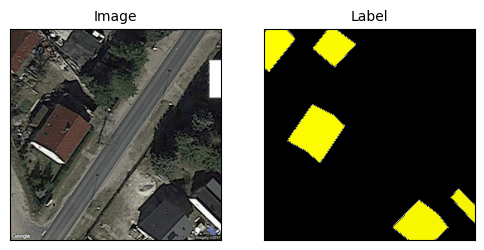

In [ ]:
!rm original/labels/278.png
!cp ./278_new_label.png original/labels/278.png

# check now the image and label are correct
image = Image.open('original/images/278.png')
label = Image.open('original/labels/278.png')
plot_row(image=image, label=label)

---


##Prepare masks for the two models




*   For instance segmentation with an mask R-CNN, I create masks where each object (a roof) has a different color/integer value. For this, I use cv2.findContours to identify the different roofs as connected regions. I set a threshold of a minimal area (1000 pixel**2) that will be accepted as instance. For the 25 masks given, this was sufficient to separate all instances correctly.
*   For image segmentation with a U-Net model, I create binary masks (roof/non-roof), as in the plots above, one could see that the borders of the roof have different color values.



In [ ]:
def mask_binary_and_instances(load_path, binary_masks_dir, instances_masks_dir, min_area, palette, plot=False):

  import cv2

  # convert mask to black and white and plot
  mask = Image.open(load_path).convert("1")
  mask = np.array(mask, dtype = np.uint8)
  mask[mask == True] = 255
  mask[mask == False] = 0

  # create new (all black mask) and write contours to it, if area is larger thresh (in pixel**2)
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
  mask = np.zeros((mask.shape[0], mask.shape[1]), np.uint8)
  bin_mask = np.zeros((mask.shape[0], mask.shape[1]), np.uint8)
  brs = {x: cv2.boundingRect(contours[x]) for x in range(len(contours))}
  brs = {key: values for key, values in brs.items() if values[2]*values[3] >= min_area}
  contours = {x: contours[x] for x in range(len(contours)) if x in list(brs.keys())}
  col_idx = 1
  for idx in brs.keys():
    cnt = contours[idx]; br = brs[idx]
    x = br[0]; y = br[1]; w = br[2]; h = br[3]
    #roi = mask[y:y+h, x:x+w]
    #plt.imshow(roi); plt.show()
    #cv2.rectangle(mask, (x,y), (x+w,y+h), col_idx, 1)
    cv2.drawContours(mask, [cnt], 0, col_idx, -1)
    cv2.drawContours(bin_mask, [cnt], 0, 255, -1)
    col_idx += 1

  # convert back to PIL image
  mask = Image.fromarray(np.array(mask, dtype=np.uint8))
  bin_mask = Image.fromarray(np.array(bin_mask, dtype=np.uint8))

  # save masks
  _, filename = os.path.split(load_path)
  if not os.path.exists(instances_masks_dir): os.makedirs(instances_masks_dir)
  mask.save(f'{instances_masks_dir}/{filename}')
  if not os.path.exists(binary_masks_dir): os.makedirs(binary_masks_dir)
  bin_mask.save(f'{binary_masks_dir}/{filename}')

  if plot:
    print('\nFile:', filename)
    print('\tbinary mask (background = 0, roof=255):', np.unique(bin_mask))
    print('\tinstances (background = 0, instances have a unique integers):', np.unique(mask))
    mask.putpalette(color_palette)
    bin_mask.putpalette([0,0,0,
                         255,255,255])
    plot_row(binary_mask=bin_mask, instances_mask=mask)



File: 121.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3 4 5]


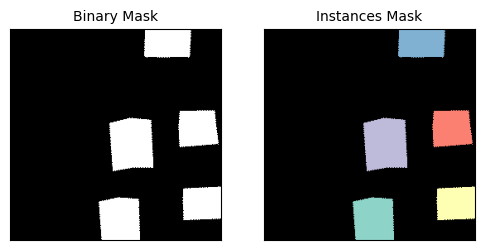


File: 241.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3]


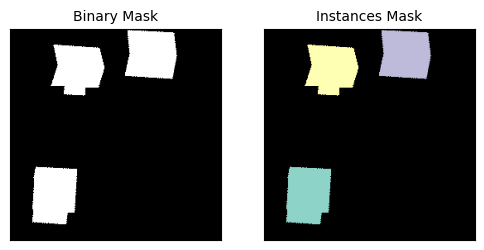


File: 270.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3 4 5 6 7]


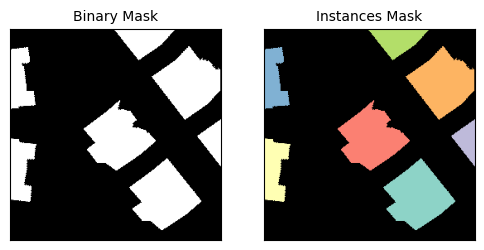


File: 272.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3 4]


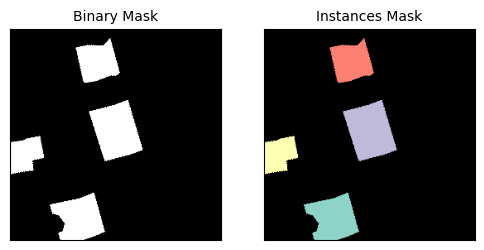


File: 274.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1]


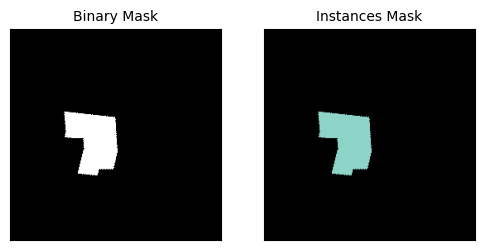


File: 278.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3 4 5]


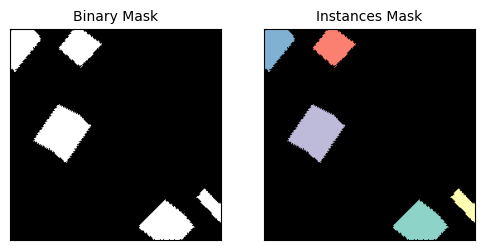


File: 284.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3 4]


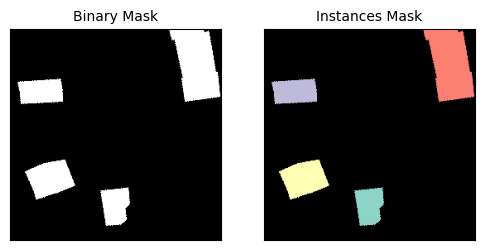


File: 287.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3 4 5]


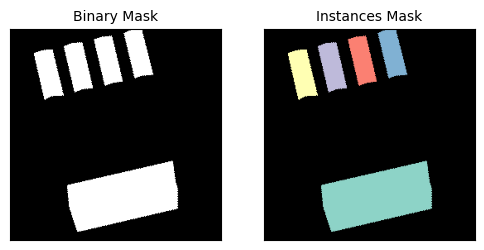


File: 300.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3]


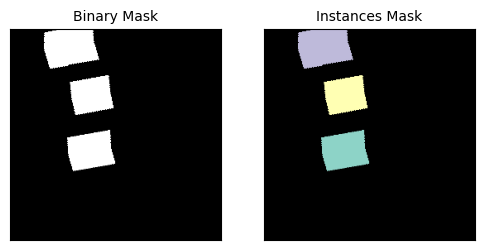


File: 301.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3]


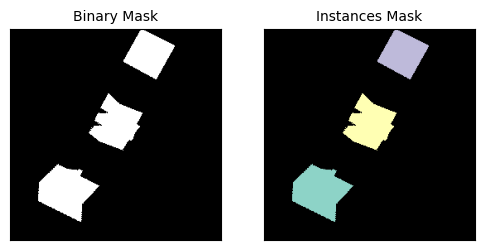


File: 303.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3]


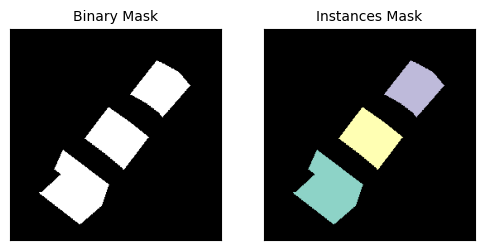


File: 308.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3]


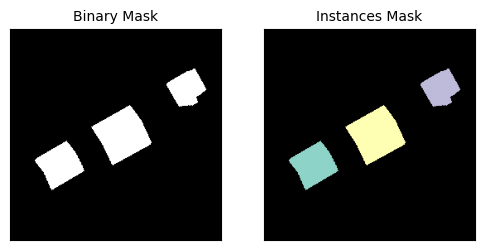


File: 314.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3]


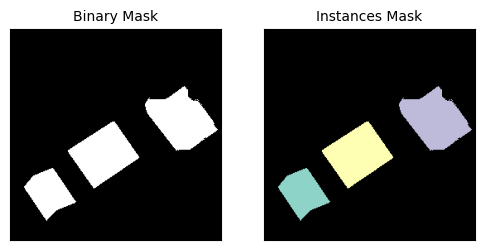


File: 315.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1]


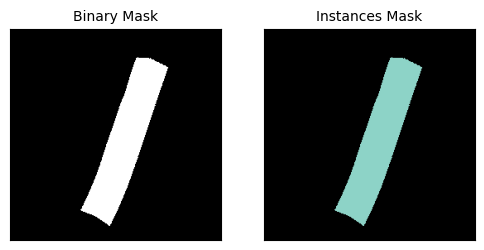


File: 317.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3 4]


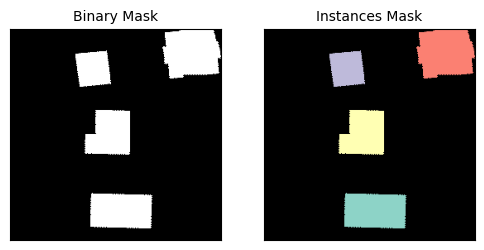


File: 320.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3]


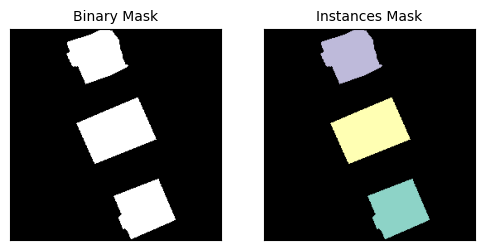


File: 324.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3 4]


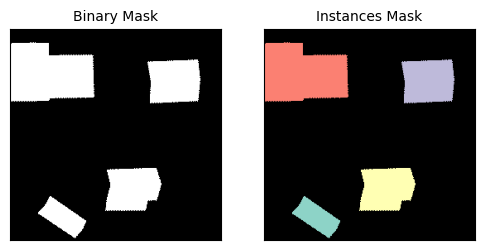


File: 328.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2]


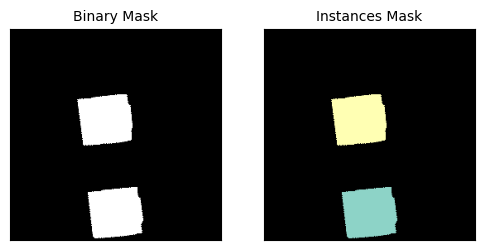


File: 337.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3]


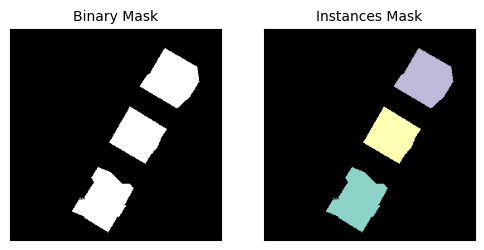


File: 343.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3 4]


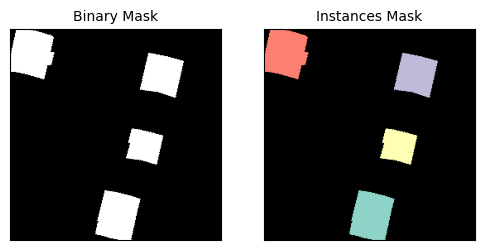


File: 345.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3]


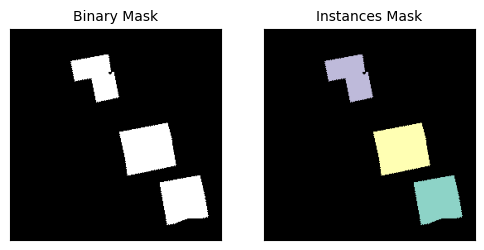


File: 379.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2]


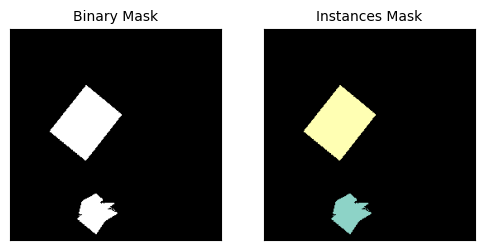


File: 381.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3 4 5]


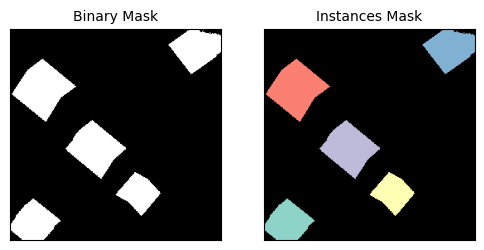


File: 417.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3]


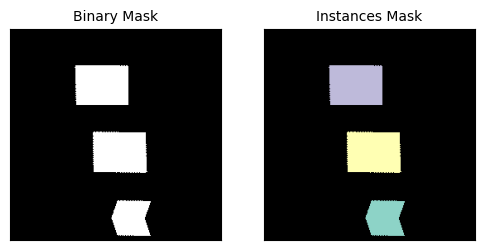


File: 532.png
	binary mask (background = 0, roof=255): [  0 255]
	instances (background = 0, instances have a unique integers): [0 1 2 3]


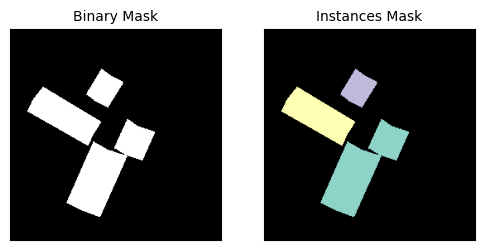

In [ ]:
# save a binary version (background/roof) of each mask and
# make another version with instances
for mask_name in sorted(os.listdir("original/labels")):
  mask_binary_and_instances(load_path=f'original/labels/{mask_name}',
                            binary_masks_dir= 'U-net/labels',
                            instances_masks_dir='mask_RCNN/instance_labels',
                            min_area=1000,
                            palette=color_palette, plot = True)

---

##Prepare Training, Validation, and Test Data

**for mask R-CNN**

In [ ]:
label_names = sorted(os.listdir('original/labels'))
image_names = sorted(os.listdir('original/images'))

train_names = label_names
test_names = [x for x in image_names if x not in label_names]
print('training samples:', image_names)
print('test samples:', test_names)

training samples: ['121.png', '241.png', '270.png', '272.png', '274.png', '278.png', '284.png', '287.png', '300.png', '301.png', '303.png', '308.png', '314.png', '315.png', '317.png', '320.png', '324.png', '328.png', '337.png', '343.png', '345.png', '379.png', '381.png', '417.png', '532.png', '535.png', '537.png', '539.png', '551.png', '553.png']
test samples: ['535.png', '537.png', '539.png', '551.png', '553.png']


In [ ]:
# copy training files to the mask R-CNN folder structure
!mkdir mask_RCNN/images
!mkdir mask_RCNN/images_test

for name in train_names:
  !cp original/images/$name mask_RCNN/images/$name

for name in test_names:
  !cp original/images/$name mask_RCNN/images_test/$name

---

**for U-net**

In [ ]:
!mkdir U-net/test U-net/test/images
!mkdir U-net/train U-net/train/images U-net/train/labels
!mkdir U-net/valid U-net/valid/images U-net/valid/labels

# make a random train/validation split
perc_valid = 0.25
n_valid = np.floor(len(image_names)*perc_valid).astype(int)
print('Split data in', len(train_names)-n_valid, 'training and', n_valid, 'valdiation images.')
valid_names = np.random.permutation(train_names)[:n_valid]

# copy training files to the U-net folder structure
for name in valid_names:
  !cp original/images/$name U-net/valid/images/$name
  !cp U-net/labels/$name U-net/valid/labels/$name

for name in [x for x in train_names if x not in valid_names]:
  !cp original/images/$name U-net/train/images/$name
  !cp U-net/labels/$name U-net/train/labels/$name

for name in test_names:
  !cp original/images/$name U-net/test/images/$name

!rm -rf U-net/labels

mkdir: cannot create directory ‘U-net/test’: File exists
mkdir: cannot create directory ‘U-net/test/images’: File exists
mkdir: cannot create directory ‘U-net/train’: File exists
mkdir: cannot create directory ‘U-net/train/images’: File exists
mkdir: cannot create directory ‘U-net/train/labels’: File exists
mkdir: cannot create directory ‘U-net/valid’: File exists
mkdir: cannot create directory ‘U-net/valid/images’: File exists
mkdir: cannot create directory ‘U-net/valid/labels’: File exists
Split data in 18 training and 7 valdiation images.


In [ ]:
%cd ..
!ls -lah

/content/my-drive/MyDrive/Projects/roof_segmentation
total 5.8M
drwx------ 5 root root 4.0K Jun 23 07:20 data
drwx------ 2 root root 4.0K Jun 23 07:01 .git
-rw------- 1 root root   21 Jun 23 07:01 .gitignore
drwx------ 2 root root 4.0K Jun 23 07:01 models
drwx------ 2 root root 4.0K Jun 23 07:01 predicted
-rw------- 1 root root 5.8M Jun 23 07:33 roof_segmentation.ipynb


---
---
---

#Object Detection and Instance Segemetation with Mask R-CNN

##Definitions and Imports

Source predefined model. Scripts cloned from https://github.com/pytorch/vision.git (with git commit -m 'checkout v.0.8.2')

In [8]:
!touch models/__init__.py
!touch models/mask_RCNN/__init__.py

In [9]:
from models.mask_RCNN import utils
from models.mask_RCNN.engine import train_one_epoch, evaluate
import torch

In [10]:
data_dir = 'data/mask_RCNN'
model_dir = 'models/mask_RCNN'
pred_dir = 'predicted/mask_RCNN'

For some reason the image I labeld myself (278.png, see 'Preparation of Data' section) makes problems during training of the mask R_CNN model. I delete the mask for this sample and move the image to test folder to use it as an additional test image.

In [11]:
if os.path.exists('data/mask_RCNN/instance_labels/278.png'):
  !rm data/mask_RCNN/instance_labels/278.png
  !mv data/mask_RCNN/images/278.png data/mask_RCNN/images_test/278.png

---

##Functions

In [12]:
# custom Compose class to be able to transform the same random transformations to the image and mask
class MyCompose(object):
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, imgs):
    for t in self.transforms:
      state = torch.get_rng_state()
      for idx in range(len(imgs)):
        torch.set_rng_state(state)
        imgs[idx] = t(imgs[idx])
    return imgs

# function that defines the transformations to be applied and instantiates an transform object
def get_transform(train, p_flip=0.5, scale_crop=(1, 1), rot_degrees=30, sharp_fac = 0.8):

  import torchvision.transforms as T

  transforms = []
  if train:
    transforms.append(T.RandomHorizontalFlip(p_flip))
    transforms.append(T.RandomResizedCrop(size=256, scale=scale_crop, antialias = True))
    transforms.append(T.RandomRotation(degrees=rot_degrees))
    transforms.append(T.RandomAdjustSharpness(sharp_fac))

  transforms.append(T.ToTensor())

  return MyCompose(transforms)

In [13]:
class roofDataset(torch.utils.data.Dataset):
    def __init__(self, root, img_mask_transforms=None, img_transforms=None):
        self.root = root
        self.img_mask_transforms = img_mask_transforms
        self.img_transforms = img_transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "instance_labels"))))

    def __getitem__(self, idx):

      from PIL import Image
      import numpy as np

      # load images ad masks
      img_path = os.path.join(self.root, "images", self.imgs[idx])
      mask_path = os.path.join(self.root, "instance_labels", self.masks[idx])
      img_orig = Image.open(img_path).convert("RGB")
      mask_orig =  Image.open(mask_path)

      # apply transformations (major modifications) to the image and mask to generate a lot of distinct samples
      if self.img_mask_transforms is not None:
        img, mask = self.img_mask_transforms([img_orig, mask_orig])
        mask = mask[0,:,:].mul(255).byte().numpy()

      # split mask (multi-class) in one mask per instance (binary)
      obj_ids = np.unique(mask)[1:] # 1st instance is background
      masks = np.concatenate([(mask[np.newaxis,:,:] == val) for val in obj_ids], axis=0)

      # get bounding box coordinates for each mask
      num_objs = len(obj_ids)
      boxes = []
      for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1]); xmax = np.max(pos[1])
        ymin = np.min(pos[0]); ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])

      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.ones((num_objs,), dtype=torch.int64)
      masks = torch.as_tensor(masks, dtype=torch.uint8)

      image_id = torch.tensor([idx])
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
      iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

      target = {'boxes': boxes, 'labels': labels, 'masks': masks, 'image_id': image_id, 'area': area, 'iscrowd': iscrowd}

      # apply transformations (minor modifications) to the image only to increase the model's robustness against noise
      if self.img_transforms is not None:
          img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
          img = self.img_transforms([img])[0]

      return img, target

    def __len__(self):
        return len(self.imgs)

In [14]:
def get_instance_segmentation_model(num_classes):

    import torchvision
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

    # load an instance segmentation model pre-trained on COCO
    # paper: https://arxiv.org/pdf/1703.06870.pdf
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [15]:
def predict_wo_label(model, img_path, save_dir=None, classify_thresh=0.75, plot = True, alpha = 0.8):

  from PIL import ImageDraw, ImageFont, Image
  import numpy as np
  import cv2
  import matplotlib.pyplot as plt
  import torch
  from copy import deepcopy as dc

  device = update_device()

  # load the image and the true mask
  img_orig = Image.open(img_path).convert('RGB')
  _, filename = os.path.split(img_path)
  print('\nSample', filename)

  # put the model in evaluation mode and predict
  model = model.double()
  model.eval()
  with torch.no_grad():
    prediction = model([torch.tensor(np.array(img_orig)/255.).permute(2, 0, 1).double().to(device)])[0]

  # plot per instance the predicted bounding box, mask, and compare to the true mask
  print('\tNr. boxes predicted:', prediction['masks'].shape[0])
  print('\tPlot only boxes with classification score >', classify_thresh)
  obj_count = 1
  for idx in range(len(prediction['scores'])):
    score = prediction['scores'][idx].cpu().numpy()
    if score > classify_thresh:
      pred = prediction['masks'][idx]
      box = prediction['boxes'][idx].cpu().numpy()
      print('\n\tInstance', idx+1, '\n\t\tClassification score:', np.round(score, 4), ' | Nr. of colors:', len(prediction['labels']))

      # draw box on original image
      box_pred = dc(img_orig)
      draw = ImageDraw.Draw(box_pred)
      draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=(255,0,0,192))
      # image-mask overlay
      overl_img = np.array(box_pred, dtype=np.uint8)
      overl_mask = np.array(pred[0,:,:].mul(255).byte().cpu(), dtype= np.uint8)
      overl_mask = cv2.cvtColor(overl_mask, cv2.COLOR_GRAY2BGR)
      overl_mask[:,:,1] = 0; overl_mask[:,:,2] = 0
      overl_img = cv2.addWeighted(overl_img, 1, overl_mask, alpha, 0)

      # predicted heatmap
      mask_hm = Image.fromarray(np.array(pred[0,:,:].mul(255).byte().cpu(), dtype= np.uint8))
      mask_hm = np.array(mask_hm, dtype = np.uint8)
      mask_arr = dc(mask_hm)
      mask_hm = Image.fromarray(np.array(mask_hm, dtype=np.uint8))

      # predicted mask
      mask_arr[mask_arr >= 255/2] = 255
      mask_arr[mask_arr < 255/2] = 0
      mask_arr = Image.fromarray(np.array(mask_arr, dtype=np.uint8))

      if (plot):
        from matplotlib import colormaps as cm
        cmap=cm.get_cmap('Reds')
        mask_arr.putpalette([0,0,0,255,255,255])
        plot_row(original_image=img_orig,
                 predicted_heatmap_and_bounding_box=overl_img,
                 fontsize=10, imagesize=4)
        plot_row(predicted_heat_map=mask_hm,
                 predicted_mask=mask_arr,
                 fontsize=10, imagesize=4, cmap=cmap)

      # save predicted masks and heat map
      if not isinstance(save_dir, type(None)):
        Image.fromarray(np.hstack([overl_img, mask_arr.convert('RGB')])[:,:,::-1]).save(f'{save_dir}/{obj_count}_{filename}')

      obj_count += 1

In [16]:
def predict_with_label(model, dataset, img_ind, classify_thresh=0.75, plot = True, alpha = 0.8):

  from PIL import ImageDraw, ImageFont, Image
  import numpy as np
  import cv2
  import matplotlib.pyplot as plt

  device = update_device()

  # load the image and the true mask
  img_orig = dataset[img_ind][0]
  input_file = dataset.masks[img_ind]
  mask_path = os.path.join(dataset.root, "instance_labels", input_file)
  masks_true = Image.open(mask_path)
  print('\nSample', input_file)

  # put the model in evaluation mode and predict
  model = model.double()
  model.eval()
  with torch.no_grad():
    prediction = model([img_orig.double().to(device)])[0]
  img_orig = Image.fromarray(dc(img_orig).mul(255).permute(1, 2, 0).byte().numpy()).convert('RGB')

  # plot per instance the predicted bounding box, mask, and compare to the true mask
  print('\tNr. boxes predicted:', prediction['masks'].shape[0])
  print('\tPlot only boxes with classification score >', np.round(classify_thresh, 2))
  for idx in range(len(prediction['scores'])):
    score = prediction['scores'][idx].cpu().numpy()
    if score > classify_thresh:
      pred = prediction['masks'][idx]
      box = prediction['boxes'][idx].cpu().numpy()
      print('\n\tInstance', idx+1, '\n\t\tScore:', score, ' | Nr. of colors:', len(prediction['labels']))

      # draw box on original image
      box_pred = dc(img_orig)
      draw = ImageDraw.Draw(box_pred)
      draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=(255,0,0,192))
      # image-mask overlay
      overl_img = np.array(box_pred, dtype=np.uint8)
      overl_mask = np.array(pred[0,:,:].mul(255).byte().cpu(), dtype= np.uint8)
      overl_mask = cv2.cvtColor(overl_mask, cv2.COLOR_GRAY2BGR)
      overl_mask[:,:,1] = 0; overl_mask[:,:,2] = 0
      overl_img = cv2.addWeighted(overl_img, 1, overl_mask, alpha, 0)

      # predicted heatmap
      mask_hm = Image.fromarray(np.array(pred[0,:,:].mul(255).byte().cpu(), dtype= np.uint8))
      mask_hm = np.array(mask_hm, dtype = np.uint8)
      #mask_hm = Image.fromarray(np.array(mask_hm, dtype=np.uint8))

      # predicted mask
      mask_arr = dc(mask_hm)
      mask_arr[mask_arr >= 255/2] = 255
      mask_arr[mask_arr < 255/2] = 0
      mask_arr = Image.fromarray(np.array(mask_arr, dtype=np.uint8))

      if (plot):
        from matplotlib import colormaps as cm
        cmap=cm.get_cmap('Reds')
        mask_arr.putpalette([0,0,0,255,255,255])
        plot_row(original_image=img_orig,
                 predicted_heatmap_and_bounding_box=overl_img,
                 fontsize=10, imagesize=4)
        plot_row(predicted_heat_map=mask_hm,
                 predicted_mask=mask_arr,
                 fontsize=10, imagesize=4, cmap=cmap)
        plot_row(true_masks_of_all_instances=masks_true,
                 fontsize=10, imagesize=4)

In [17]:
def predict_dataset(model, dataset):
  device = update_device()

  for x in range(len(dataset)):
    predict_with_label(model=model, dataset=dataset, img_ind=x, classify_thresh=settings['prediction']['classify_thresh'], plot = settings['prediction']['plot_predicted'])

def predict_test():
  device = update_device()

  test_names = os.listdir(os.path.join(dataset.root, "images_test"))
  test_paths = [os.path.join(dataset.root, 'images_test', x) for x in test_names]

  for test_path in test_paths:
    predict_wo_label(model=model, img_path = test_path, save_dir = pred_dir, classify_thresh=settings['prediction']['classify_thresh'], plot = settings['prediction']['plot_predicted'])

In [18]:
def get_input(dataset, idx = None, plot = True):

  if isinstance(idx, type(None)): idx = torch.randint(low=0, high=len(dataset), size=torch.tensor([0]).size())
  file_name = dataset.masks[idx]
  img_orig = Image.open(os.path.join(dataset.root, "images", file_name))
  masks_orig = Image.open(os.path.join(dataset.root, "instance_labels", file_name))

  if plot:
    print('Input image and mask for sample', file_name)
    plot_row(original_image=img_orig, orginal_mask=masks_orig)
  else:
    return img_orig, masks_orig


In [19]:
def train(model, num_epochs, trained_epochs,
          losses, best_loss, metrics, data_loader_train, data_loader_valid,
          optim, lr_sched, save_path):
  from io import StringIO
  import sys
  import re

  device = update_device()
  model = model.float()

  print('\nTrain the model for', num_epochs, 'epochs:')
  for epoch in range(trained_epochs+1, trained_epochs+num_epochs+1):
    print('\nEpoch', epoch)
    # train for one epoch, printing every x iterations
    metric_logger = train_one_epoch(model, optim, data_loader_train, device, epoch, print_freq=settings['training']['print_freq'])
    loss = re.findall("\d+\.\d+", str(metric_logger.meters['loss']))
    loss_classifier = re.findall("\d+\.\d+", str(metric_logger.meters['loss_classifier']))
    loss_box = re.findall("\d+\.\d+", str(metric_logger.meters['loss_box_reg']))
    loss_mask = re.findall("\d+\.\d+", str(metric_logger.meters['loss_mask']))
    losses['loss'].append((float(loss[0]), float(loss[1])))
    losses['loss_classifier'].append((float(loss_classifier[0]), float(loss_classifier[1])))
    losses['loss_box'].append((float(loss_box[0]), float(loss_box[1])))
    losses['loss_mask'].append((float(loss_mask[0]), float(loss_mask[1])))

    # update the learning rate
    lr_sched.step()

    # evaluate on the validation dataset
    if device.type == 'cuda':
      coco_evaluator = evaluate(model.float(), data_loader_valid, device=device)

      stdout_bckp = sys.stdout
      summary = StringIO()
      sys.stdout = summary
      print(coco_evaluator.summarize())
      sys.stdout = stdout_bckp
      summary = summary.getvalue()

      prec_rec = []
      for item in summary.split('IoU metric')[2].split("\n"):
        # 'IoU=0.50' means only object proposed with IoU >= 0.5 are included in precision, recall and f1 metric
        # 'IoU=0.50:0.95' means average (maP for precision and maR for recall) over different IoU thresholds, from 0.5 to 0.95, step 0.05 (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95)

        if ("IoU=0.50" in item) & ('maxDets=100' in item) & ('area=   all' in item):
            prec_rec.append(float(item.split('=')[-1]))
      metrics['precision_mask'].append(prec_rec[0])
      metrics['recall_mask'].append(prec_rec[1])
      if (prec_rec[0]+prec_rec[1]) != 0:
        metrics['f1_mask'].append(2*prec_rec[0]*prec_rec[1]/(prec_rec[0]+prec_rec[1]))
      else:
        metrics['f1_mask'].append(0)
      print('Precision, Recall, and F1 segmentation scores at min. IoU 0.50 and 100 objects proposed max:',
            np.round(metrics['precision_mask'][-1],4),  np.round(metrics['recall_mask'][-1], 4), np.round(metrics['f1_mask'][-1], 4))

      trained_epochs += 1

      # save model if total validation loss decreased
      if float(loss[1]) < best_loss:
        best_loss = float(loss[1])

        torch.save(model, f'{save_path}/model.pth')
        pickle.dump(metrics, open(f'{model_dir}/metrics', 'wb'))
        pickle.dump(losses, open(f'{model_dir}/losses', 'wb'))
        pickle.dump(trained_epochs, open(f'{model_dir}/trained_epochs', 'wb'))
        pickle.dump(optim, open(f'{model_dir}/optimizer', 'wb'))
        pickle.dump(lr_sched, open(f'{model_dir}/lr_scheduler', 'wb'))

        print('Model saved. Total loss:', loss[1], '\n')

    else:
      print("Evaluation currently only works on GPU. Repair code.")

---

##Train mask R-CNN Model

**Check Transformations to training data**

In [20]:
dataset_transf = roofDataset('data/mask_RCNN',
                      img_mask_transforms = get_transform(train = True, p_flip = 0.5, scale_crop = (1, 1), rot_degrees = 45, sharp_fac = 0.75),
                      img_transforms = get_transform(train = True, p_flip = 0, scale_crop = (0.95, 1.05), rot_degrees = 5, sharp_fac = 1))
dataset = roofDataset('data/mask_RCNN',
                      img_mask_transforms = get_transform(train = False),
                      img_transforms = get_transform(train = False))

# only for looking at the data formats as used in the model
data_transf_loader = torch.utils.data.DataLoader(
    dataset_transf, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn
)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn
)


loading:
	instances mask: [0 1 2 3] L -> L
	for plotting with palette r, g, b: [  0 141 190 255] [  0 186 211 255] [  0 179 199 218] L -> RGB

1. Apply the same random transformations to image and mask to create more training data

	Top: Original image and mask.
	Bottom: The same major random transformation applied to the image and mask.


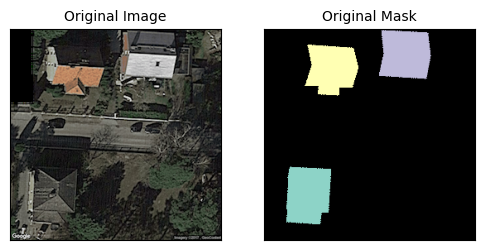

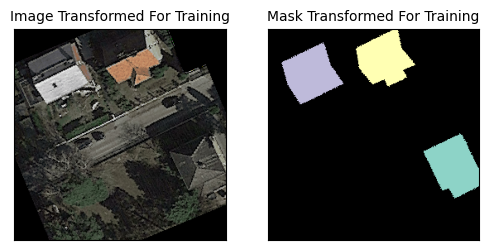


2. Apply minor random transformations only to the image for model robustness

	Left: The tranformed image from above.
Right: Minor random transformations to the image only (i.e. image rotated up to +/- 2.5 degrees and scaled up to 5% relative to the mask).


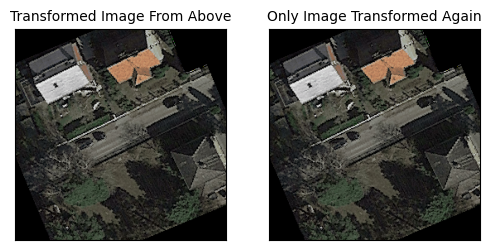

In [21]:
# test for one sample
mask_img_name = '241.png'

# how the original images and masks must be loaded and converted for plotting
img_mask_transformer = get_transform(train = True, p_flip = 0.5, scale_crop = (1, 1), rot_degrees = 90, sharp_fac = 0.8)
img = Image.open(f'data/mask_RCNN/images/{mask_img_name}').convert("RGB");
mask = Image.open(f'data/mask_RCNN/instance_labels/{mask_img_name}'); type_mask_load = mask.mode
mask_plot = dc(mask); mask_plot.putpalette(color_palette); mask_plot = mask_plot.convert('RGB')
print('loading:\n\tinstances mask:', np.unique(np.array(mask)), type_mask_load, '->', mask.mode)
print('\tfor plotting with palette r, g, b:', np.unique(np.array(mask_plot)[:,:,0]), np.unique(np.array(mask_plot)[:,:,1]), np.unique(np.array(mask_plot)[:,:,2]), type_mask_load, '->', mask_plot.mode)

# transformation to mask and image
print('\n1. Apply the same random transformations to image and mask to create more training data')
img_tens, mask_tens = img_mask_transformer([img, mask])
img_trans =  Image.fromarray(img_tens.mul(255).permute(1, 2, 0).byte().numpy())
#print('\ttransformed tensor image:', np.array(img_tens).shape,
#      '\n\ttransformed image:', np.array(img_trans).shape)

mask_trans = mask_tens[0,:,:].mul(255).byte().numpy()
mask_trans_plot = Image.fromarray(dc(mask_trans)); type_mask_trans = mask_trans_plot.mode; mask_trans_plot.putpalette(color_palette); mask_trans_plot = mask_trans_plot.convert('RGB')
#print('\n\ttransformed tensor mask', np.array(mask_tens).shape, np.unique(np.array(mask_tens*255, dtype=np.uint8)),
#      '\n\ttransformed mask', np.array(mask_trans).shape, np.unique(mask_trans), type_mask_trans, '->', type(mask_trans),
#      '\n\tmask transformed for plotting r, g, b:', np.unique(np.array(mask_trans_plot)[:,:,0]), np.unique(np.array(mask_trans_plot)[:,:,1]), np.unique(np.array(mask_trans_plot)[:,:,2]), type_mask_trans, '->', mask_trans_plot.mode)

print('\n\tTop: Original image and mask.\n\tBottom: The same major random transformation applied to the image and mask.')
plot_row(original_image=img, original_mask=mask_plot)
plot_row(image_transformed_for_training=img_trans, mask_transformed_for_training=mask_trans_plot)

# transformation only to image
print('\n2. Apply minor random transformations only to the image for model robustness')
img_transformer = get_transform(train = True, p_flip = 0, scale_crop = (0.95, 1), rot_degrees = 2.5, sharp_fac=0.95)
img_tens = img_transformer([img_trans])[0]
img_trans_2 =  Image.fromarray(img_tens.mul(255).permute(1, 2, 0).byte().numpy())

print('\n\tLeft: The tranformed image from above.\nRight: Minor random transformations to the image only (i.e. image rotated up to +/- 2.5 degrees and scaled up to 5% relative to the mask).')
plot_row(transformed_image_from_above=img_trans, only_image_transformed_again=img_trans_2)

del(dataset_transf, dataset, data_transf_loader, data_loader)

---

**Instantiate new or load trained model**

In [22]:
settings = {'transforms': {'img_mask': {'p_flip': 0.5, 'scale_crop': (1,1), 'rot_degrees': 90, 'sharp_fac': 0.8},
                           'img_only': {'p_flip': 0, 'scale_crop': (1,1), 'rot_degrees': 2.5, 'sharp_fac': 0.95}},
            'training': {'print_freq': 10, 'share_valid': 0.3,
                         # data loader
                         'batch_size': 2, 'num_workers': 2,
                         # optimizer and lr scheduler
                         'lr': 0.005, 'momentum': 0.9, 'weight_decay': 0.0005, 'step_size': 0.3, 'gamma': 0.1},
            'prediction': {'classify_thresh': 0.85, 'plot_predicted': True}}

In [23]:
from torch.optim.lr_scheduler import StepLR
import pickle

# initialize dataloaders
device = update_device()
dataset_transf = roofDataset('data/mask_RCNN',
                             img_mask_transforms = get_transform(train = True,
                                                                 p_flip = settings['transforms']['img_mask']['p_flip'],
                                                                 scale_crop = settings['transforms']['img_mask']['scale_crop'],
                                                                 rot_degrees = settings['transforms']['img_mask']['rot_degrees'],
                                                                 sharp_fac = settings['transforms']['img_mask']['sharp_fac']),
                             img_transforms = get_transform(train = True,
                                                            p_flip = settings['transforms']['img_only']['p_flip'],
                                                            scale_crop = settings['transforms']['img_only']['scale_crop'],
                                                            rot_degrees = settings['transforms']['img_only']['rot_degrees'],
                                                            sharp_fac = settings['transforms']['img_only']['sharp_fac']))
data_transf_loader = torch.utils.data.DataLoader(dataset_transf, batch_size=settings['training']['batch_size'], shuffle=True, num_workers=settings['training']['num_workers'], collate_fn=utils.collate_fn)
dataset = roofDataset('data/mask_RCNN',
                      img_mask_transforms = get_transform(train = False),
                      img_transforms = get_transform(train = False))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=settings['training']['batch_size'], shuffle=True, num_workers=settings['training']['num_workers'], collate_fn=utils.collate_fn)

# random train/validation split
indices = torch.randperm(len(dataset)).tolist()
n_samples = len(indices); n_valid = np.array(np.floor(n_samples * settings['training']['share_valid']), dtype=int)
train_inds = indices[:-n_valid]
valid_inds = indices[-n_valid:]
dataset_train = torch.utils.data.Subset(dataset_transf, train_inds)
dataset_valid = torch.utils.data.Subset(dataset, valid_inds)
print('Split dataset in', len(dataset_train), 'training samples and ', len(dataset_valid), 'validation samples.')


Split dataset in 17 training samples and  7 validation samples.


In [24]:
# load previously trained model or instantiate a new one
new_model = False

if new_model:
  print('Created a new model.')

  # instantiate model
  model = get_instance_segmentation_model(num_classes = 2).to(device)
  trained_epochs = 0
  best_loss = 10**8

  # construct an optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=settings['training']['lr'], momentum=settings['training']['momentum'], weight_decay=settings['training']['weight_decay'])

  # and a step learning rate scheduler which decreases the learning rate by 10x every 3 epochs
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=settings['training']['step_size'], gamma=settings['training']['gamma'])

  losses = {'loss': [], 'loss_classifier': [], 'loss_box': [], 'loss_mask': []}
  metrics = {'precision_mask': [], 'recall_mask': [], 'f1_mask': []}
else:
  if os.path.exists(f'{model_dir}/model.pth'):
      model = torch.load(f'{model_dir}/model.pth', map_location=device)
      metrics = pickle.load(open(f'{model_dir}/metrics', 'rb'))
      losses = pickle.load(open(f'{model_dir}/losses', 'rb'))
      best_loss = min(losses['loss'])
      trained_epochs = pickle.load(open(f'{model_dir}/trained_epochs', 'rb'))
      optimizer = pickle.load(open(f'{model_dir}/optimizer', 'rb'))
      lr_scheduler = pickle.load(open(f'{model_dir}/lr_scheduler', 'rb'))
      print('Loaded model.')
  else: print('No model found.')

Created a new model.


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 158MB/s]


---

**Train or re-train the model**

In [76]:
num_epochs = 100

# saves model with least total loss
train(model=model, num_epochs=num_epochs, trained_epochs=trained_epochs,
      losses=losses, best_loss=best_loss, metrics=metrics,
      data_loader_train=data_transf_loader, data_loader_valid=data_loader,
      optim=optimizer, lr_sched=lr_scheduler,
      save_path=model_dir)

# load best model
model = torch.load(f'{model_dir}/model.pth', map_location=device)
metrics = pickle.load(open(f'{model_dir}/metrics', 'rb'))
losses = pickle.load(open(f'{model_dir}/losses', 'rb'))
trained_epochs = pickle.load(open(f'{model_dir}/trained_epochs', 'rb'))
optimizer = pickle.load(open(f'{model_dir}/optimizer', 'rb'))
lr_scheduler = pickle.load(open(f'{model_dir}/lr_scheduler', 'rb'))
print('\nLoaded model from best epoch in terms of total validation loss.')


Train the model for 100 epochs:

Epoch 1
Epoch: [1]  [ 0/12]  eta: 0:00:20  lr: 0.005000  loss: 3.2485 (3.2485)  loss_classifier: 0.7558 (0.7558)  loss_box_reg: 0.5055 (0.5055)  loss_mask: 1.8008 (1.8008)  loss_objectness: 0.1581 (0.1581)  loss_rpn_box_reg: 0.0283 (0.0283)  time: 1.6709  data: 1.0803  max mem: 3476
Epoch: [1]  [10/12]  eta: 0:00:01  lr: 0.005000  loss: 1.6618 (1.7960)  loss_classifier: 0.2730 (0.3142)  loss_box_reg: 0.3274 (0.3584)  loss_mask: 0.8310 (1.0273)  loss_objectness: 0.0842 (0.0788)  loss_rpn_box_reg: 0.0160 (0.0173)  time: 0.5842  data: 0.1148  max mem: 3476
Epoch: [1]  [11/12]  eta: 0:00:00  lr: 0.005000  loss: 1.5605 (1.7565)  loss_classifier: 0.2702 (0.3075)  loss_box_reg: 0.3188 (0.3548)  loss_mask: 0.7421 (0.9997)  loss_objectness: 0.0617 (0.0768)  loss_rpn_box_reg: 0.0160 (0.0177)  time: 0.5721  data: 0.1058  max mem: 3476
Epoch: [1] Total time: 0:00:06 (0.5788 s / it)
creating index...
index created!
Test:  [ 0/12]  eta: 0:00:07  model_time: 0.3607 (

---

**Plot losses and metrics**

In [79]:
# end of epoch losses (explanations copied from the mask R-CNN paper https://arxiv.org/pdf/1703.06870.pdf and faster R-CNN paper https://arxiv.org/pdf/1504.08083.pdf):
#   loss_classifier:
#     Lcls(p, u) = − log(p_u) is log loss for true class u
#   loss_box:
#     Lloc, is defined over a tuple of true bounding-box regression targets for class u, v = (v_x, v_y, v_w, v_h), and a predicted tuples again for class u
#   loss_mask:
#     The mask branch has a Km2-dimensional output for each RoI, which encodes K binary masks of resolution m × m, one for each of the K classes.
#     To this we apply a per-pixel sigmoid, and define Lmask as the average binary cross-entropy loss.
#   loss:
#     L = Lcls + Lbox + Lmask

losses_train = pd.DataFrame({key: [value[0] for value in values] for key, values in losses.items()}).astype(float)
losses_valid = pd.DataFrame({key: [value[1] for value in values] for key, values in losses.items()}).astype(float)
losses_valid.T

0       1       2       3       4       5       6   \
loss             1.7565  1.2598  1.1874  1.1232  0.9357  0.9312  0.8425   
loss_classifier  0.3075  0.2524  0.2503  0.2516  0.1911  0.2018  0.1824   
loss_box         0.3548  0.3613  0.4043  0.3903  0.3266  0.3335  0.3208   
loss_mask        0.9997  0.5849  0.4754  0.4307  0.3787  0.3610  0.3037   

                     7       8       9   ...      78      79      80      81  \
loss             0.8274  0.7619  0.7352  ...  0.5243  0.5126  0.5435  0.4655   
loss_classifier  0.1820  0.1665  0.1766  ...  0.1239  0.1252  0.1327  0.1183   
loss_box         0.3209  0.2856  0.2616  ...  0.1860  0.1923  0.1926  0.1673   
loss_mask        0.3008  0.2854  0.2682  ...  0.1977  0.1776  0.1989  0.1617   

                     82      83      84      85      86      87  
loss             0.5009  0.4478  0.4688  0.4765  0.5121  0.4371  
loss_classifier  0.1197  0.1091  0.1081  0.1176  0.1238  0.1081  
loss_box         0.1781  0.1651  0.1687  0.1698  0.1811  0.1635  
loss_mask        0.1901  0.1603  0.1762  0.1737  0.1921  0.1542  

[4 rows x 88 columns]

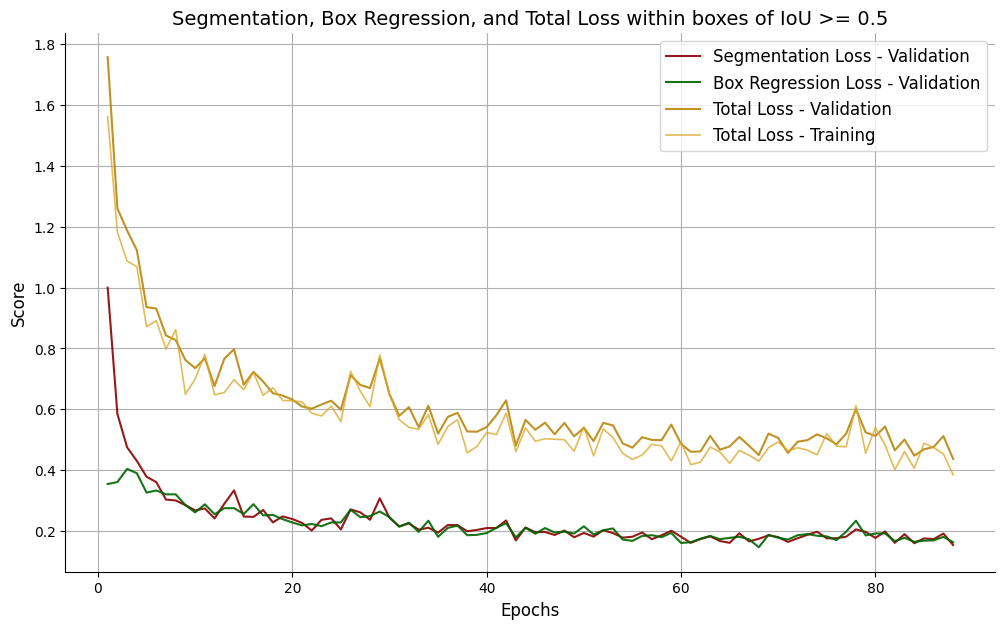

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))
# loss_mask = binary cross entropy
ax.plot((losses_valid.index+1).tolist(), losses_valid.loss_mask.tolist(), lw=1.5, color='darkred', alpha=0.9, label = 'Segmentation Loss - Validation')
# loss_box
ax.plot((losses_valid.index+1).tolist(), losses_valid.loss_box.tolist(), lw=1.5,  color='darkgreen', alpha=0.9, label = 'Box Regression Loss - Validation')
#total loss
ax.plot((losses_valid.index+1).tolist(), losses_valid.loss.tolist(), lw=1.5,  color='darkgoldenrod', alpha=0.9, label = 'Total Loss - Validation')
ax.plot((losses_train.index+1).tolist(), losses_train.loss.tolist(), lw=1.2,  color='goldenrod', alpha=0.75, label = 'Total Loss - Training')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Segmentation, Box Regression, and Total Loss within boxes of IoU >= 0.5', fontsize=14)
#plt.ylim([0, 1]); #plt.xlim([1, trained_epochs])
ax.legend(loc='best', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.grid()
plt.show()

In [81]:
# use the mask loss as cross entropy metric as it was too complicated to add other metrics to the coco model
metrics = pd.DataFrame(metrics).astype(float)
metrics['cross_entropy_mask_train'] = losses_train['loss_mask']
metrics['cross_entropy_mask_valid'] = losses_valid['loss_mask']
metrics.T

0         1         2         3         4   \
precision_mask            0.0000  0.098000  0.267000  0.381000  0.374000   
recall_mask               0.0020  0.285000  0.570000  0.760000  0.807000   
f1_mask                   0.0000  0.145849  0.363656  0.507555  0.511123   
cross_entropy_mask_train  0.7421  0.560500  0.429800  0.424800  0.357300   
cross_entropy_mask_valid  0.9997  0.584900  0.475400  0.430700  0.378700   

                                5         6         7         8         9   \
precision_mask            0.442000  0.485000  0.593000  0.550000  0.599000   
recall_mask               0.857000  0.859000  0.932000  0.890000  0.930000   
f1_mask                   0.583209  0.619963  0.724821  0.679861  0.728672   
cross_entropy_mask_train  0.345500  0.277000  0.320500  0.266800  0.245400   
cross_entropy_mask_valid  0.361000  0.303700  0.300800  0.285400  0.268200   

                          ...       78        79        80        81  \
precision_mask            ...  0.59100  0.605000  0.736000  0.711000   
recall_mask               ...  0.80800  0.799000  0.878000  0.866000   
f1_mask                   ...  0.68267  0.688597  0.800753  0.780883   
cross_entropy_mask_train  ...  0.17870  0.173100  0.191100  0.154800   
cross_entropy_mask_valid  ...  0.19770  0.177600  0.198900  0.161700   

                                82        83        84        85        86  \
precision_mask            0.802000  0.763000  0.693000  0.767000  0.706000   
recall_mask               0.941000  0.901000  0.832000  0.904000  0.882000   
f1_mask                   0.865958  0.826278  0.756165  0.829884  0.784247   
cross_entropy_mask_train  0.169100  0.158000  0.152500  0.145700  0.180200   
cross_entropy_mask_valid  0.190100  0.160300  0.176200  0.173700  0.192100   

                                87  
precision_mask            0.776000  
recall_mask               0.914000  
f1_mask                   0.839366  
cross_entropy_mask_train  0.150100  
cross_entropy_mask_valid  0.154200  

[5 rows x 88 columns]

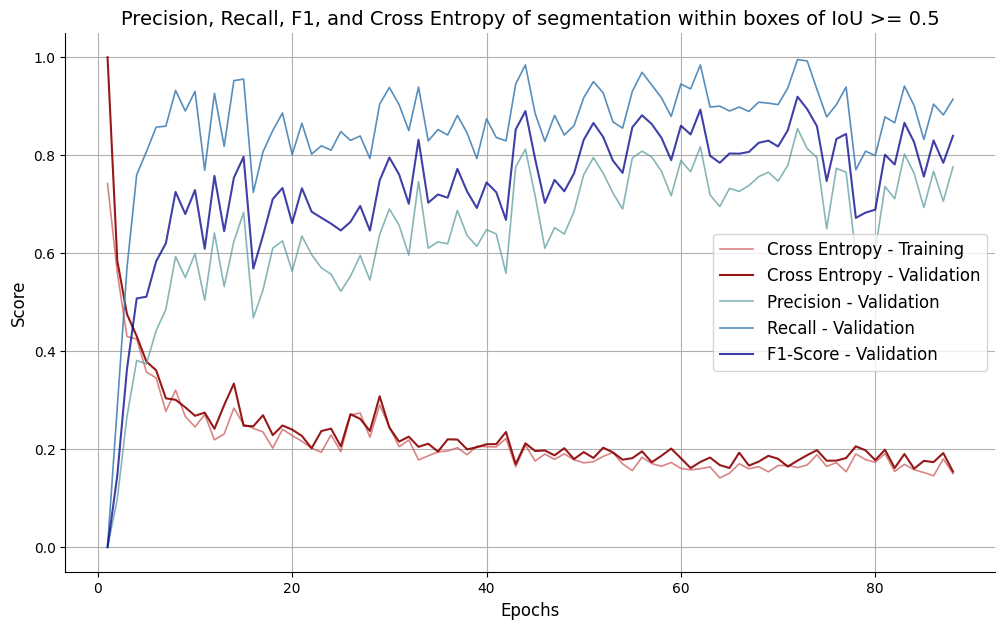

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))
# cross entropy metric = segementation loss ('mask_loss')
ax.plot((metrics.index+1).tolist(), metrics.cross_entropy_mask_train.tolist(), lw=1.2, color='indianred', alpha=0.75, label = 'Cross Entropy - Training')
ax.plot((metrics.index+1).tolist(), metrics.cross_entropy_mask_valid.tolist(), lw=1.5, color='darkred', alpha=0.9, label = 'Cross Entropy - Validation')
# precision
ax.plot((metrics.index+1).tolist(), metrics.precision_mask.tolist(), lw=1.2,  color='cadetblue', alpha=0.75, label = 'Precision - Validation')
# recall
ax.plot((metrics.index+1).tolist(), metrics.recall_mask.tolist(), lw=1.2,  color='steelblue', alpha=0.9, label = 'Recall - Validation')
# f1-score (qualitatively same behaviour as IoU metric)
ax.plot((metrics.index+1).tolist(), metrics.f1_mask.tolist(), lw=1.5,  color='darkblue', alpha=0.75, label = 'F1-Score - Validation')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision, Recall, F1, and Cross Entropy of segmentation within boxes of IoU >= 0.5', fontsize=14)
#plt.ylim([0, 1]); #plt.xlim([1, trained_epochs])
ax.legend(loc='best', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.grid()
plt.show()

---

##Prediction

In [83]:
# predict on untransformed training/validation samples
#predict_dataset(model=model, dataset=dataset)

---

**Predict test images**

In [86]:
predict_test()

Output hidden; open in https://colab.research.google.com to view.

---
---
---

#Image Segementation with U-Net

##Definitions and Imports

In [7]:
data_dir = f'{proj_dir}/data/U-net'
model_dir = f'{proj_dir}/models/U-net'
pred_dir = f'{proj_dir}/predicted/U-net'

x_train_dir = f'{data_dir}/train/images'
y_train_dir = f'{data_dir}/train/labels'
x_valid_dir = f'{data_dir}/valid/images'
y_valid_dir = f'{data_dir}/valid/labels'
x_test_dir = f'{data_dir}/test/images'

In [8]:
import random

import warnings
warnings.filterwarnings("ignore")

import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

from segmentation_models_pytorch import utils

In [9]:
class_names = ['background', 'roof']
class_rgb_values  = [[0, 0, 0], [255, 255, 255]]

---

##Functions

In [10]:
# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs (e.g. used for converting predicted heat maps to the class with max. predicted value, here: create binary masks)
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode

        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        #self.down_conv4 = DownBlock(256, 512)

        # Bottleneck
        #self.double_conv = DoubleConv(512, 1024)
        self.double_conv = DoubleConv(256, 512)

        # Upsampling Path
        #self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)

        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        #x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        #x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [12]:
class roofDataset(torch.utils.data.Dataset):

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
          sample = self.augmentation(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
          sample = self.preprocessing(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']

        # normalize colors in each channel
        #print(type(image), np.array(image).shape, len(np.unique(np.array(image))), np.array(image).dtype)
        #image = standardize(image)
        #print(type(image), np.array(image).shape, len(np.unique(np.array(image))), np.array(image).dtype)

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

In [13]:
def stand_channel(img, channel, **kwargs):
  img = img[:,:,channel]
  mean = rgb_mean[channel]
  std = rgb_std[channel]
  img = (img - mean) / std
  return img.astype(np.float32)

def standardize(arr, **kwargs):
  # disabled currently, as working with non-standardized data brough better results

  #arr = np.array(arr, dtype=np.float32)
  #r_channel = stand_channel(img=arr, channel=0)
  #g_channel = stand_channel(img=arr, channel=1)
  #b_channel = stand_channel(img=arr, channel=2)
  #arr = np.stack([r_channel, g_channel, b_channel], axis=-1)

  #reduce gray
  #min_channel_vals = np.min(arr, axis=-1)
  #arr = arr - np.stack([min_channel_vals, min_channel_vals, min_channel_vals], axis=-1)

  # remove green
  #arr[:,:,1] = 0#np.min(arr[:,:,[0,2]])
  return arr

def get_training_augmentation():
    train_transform = [
        album.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        album.RandomCrop(height=256, width=256, always_apply=True),

        album.HorizontalFlip(p=0.5),
        album.RandomResizedCrop(height = 256, width=256, scale=(0.2,1), p = 1.),
        album.augmentations.geometric.rotate.Rotate(limit=90, p = 1),

        #album.augmentations.transforms.RGBShift()
        #album.augmentations.transforms.ChannelShuffle()
      ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        album.RandomCrop(height=256, width=256, always_apply=True)
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

def get_preprocessing_vis(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))

    return album.Compose(_transform)

In [14]:
def crop_image(image, target_image_dims=[256,256,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

---

##Train U-net model

**Check how the training data are transformed**

In [33]:
# dataset for training
train_dataset = roofDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=standardize),
    class_rgb_values=class_rgb_values,
)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2)

# this one gets transformed, but not converted to tensor
train_dataset_vis = roofDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing_vis(preprocessing_fn=standardize),
    class_rgb_values=class_rgb_values,
)

# this one does nothing, just load the unmodified images
train_dataset_blank = roofDataset(
    x_train_dir, y_train_dir,
    preprocessing=get_preprocessing_vis(preprocessing_fn=standardize),
    class_rgb_values=class_rgb_values,
)

# this one just loads validation images and masks
valid_dataset = roofDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=standardize),
    class_rgb_values=class_rgb_values,
)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

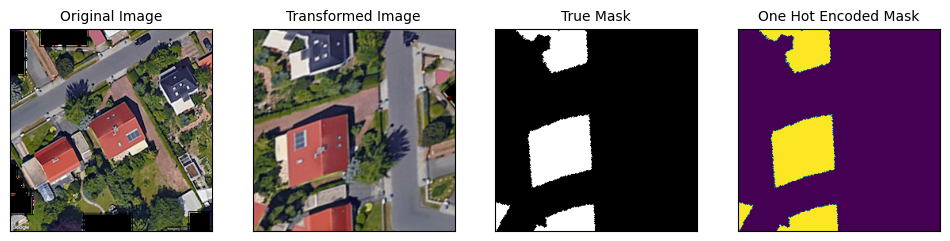

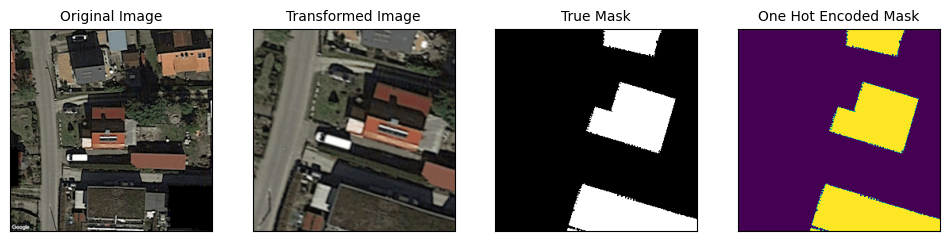

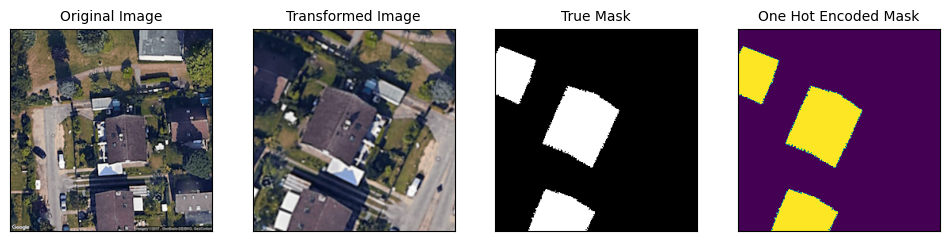

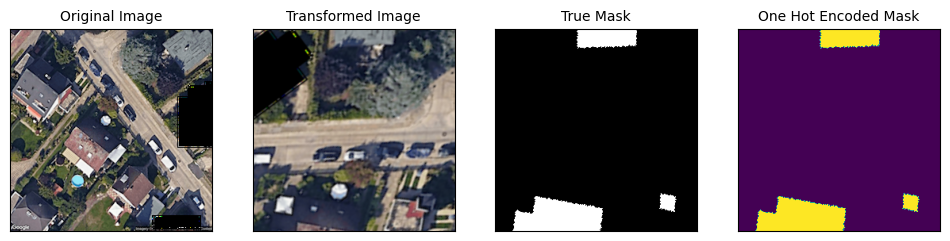

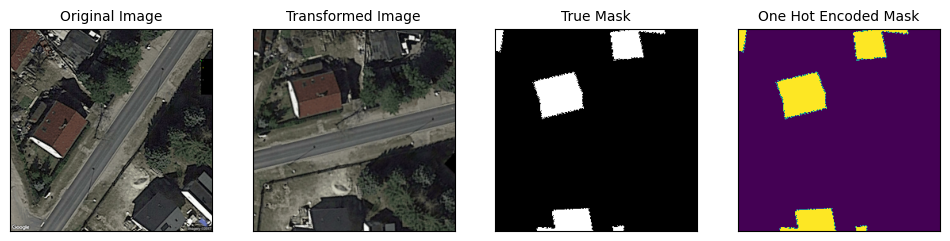

In [19]:
for i in range(5):
  idx = random.randint(0, len(train_dataset)-1)
  image_orig, _ = train_dataset_blank[idx]
  image, mask = train_dataset_vis[idx]

  plot_row(
      original_image=image_orig,
      transformed_image = image,
      true_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
      one_hot_encoded_mask = np.array(reverse_one_hot(mask)) # one-hot-encoding comes from multi-class problems, would't be really necessary for this binary task, but it is implemented that way
  )

---

**Instantiate new or load trained model**

In [15]:
device = update_device()

# define loss function - binary cross entropy showed best performance in terms of IoU and F1 metric
loss = utils.losses.CrossEntropyLoss()
#loss = utils.losses.DiceLoss()
#loss = utils.losses.JaccardLoss()
#loss = utils.losses.CrossEntropyLoss()  + utils.losses.JaccardLoss()

# define metrics
metrics = [
    utils.metrics.IoU(),
    utils.metrics.Fscore(beta=1),
    utils.metrics.Precision(),
    utils.metrics.Recall()
]

In [17]:
# load previously trained model or instantiate a new one
new_model = False

if new_model:
  print('Created a new model.')

  model = UNet(up_sample_mode = 'bilinear')
  trained_epochs = 0

  optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=5e-4),])
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 2, eta_min=5e-5)#T_0=1, T_mult=2, eta_min=5e-5)

  train_epoch = smp.utils.train.TrainEpoch(model, loss=loss, metrics=metrics, optimizer=optimizer, device=device, verbose=True)
  valid_epoch = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics, device=device, verbose=True)

  iou = 0.0
  train_logs_list, valid_logs_list = [], []
else:
  if os.path.exists(f'{model_dir}/model.pth'):
      model = torch.load(f'{model_dir}/model.pth', map_location=device)
      metrics = pickle.load(open(f'{model_dir}/metrics', 'rb'))
      iou = metrics['iou_score']
      trained_epochs = pickle.load(open(f'{model_dir}/trained_epochs', 'rb'))
      optimizer = pickle.load(open(f'{model_dir}/optimizer', 'rb'))
      lr_scheduler = pickle.load(open(f'{model_dir}/lr_scheduler', 'rb'))
      train_epoch = pickle.load(open(f'{model_dir}/train_epoch', 'rb'))
      valid_epoch = pickle.load(open(f'{model_dir}/valid_epoch', 'rb'))
      train_logs_list = pickle.load(open(f'{model_dir}/train_logs_list', 'rb'))
      valid_logs_list = pickle.load(open(f'{model_dir}/valid_logs_list', 'rb'))
      print('Loaded model.')
  else: print('No model found.')

Loaded model.


---

**Train or re-train the model**

In [71]:
num_epochs = 100

for epoch in range(trained_epochs+1, trained_epochs+num_epochs+1):
    trained_epochs += 1

    # training and validation
    print('\nEpoch: {}'.format(epoch))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)

    # save model if validation IoU score imporoved
    if iou < valid_logs['iou_score']:
        iou = valid_logs['iou_score']
        metrics = valid_logs

        # save
        torch.save(model, f'{model_dir}/model.pth')
        pickle.dump(metrics, open(f'{model_dir}/metrics', 'wb'))
        pickle.dump(trained_epochs, open(f'{model_dir}/trained_epochs', 'wb'))
        pickle.dump(optimizer, open(f'{model_dir}/optimizer', 'wb'))
        pickle.dump(lr_scheduler, open(f'{model_dir}/lr_scheduler', 'wb'))
        pickle.dump(train_epoch, open(f'{model_dir}/train_epoch', 'wb'))
        pickle.dump(valid_epoch, open(f'{model_dir}/valid_epoch', 'wb'))
        pickle.dump(train_logs_list, open(f'{model_dir}/train_logs_list', 'wb'))
        pickle.dump(valid_logs_list, open(f'{model_dir}/valid_logs_list', 'wb'))

        print('Saved model.')

# load best model
model = torch.load(f'{model_dir}/model.pth', map_location=device)
metrics = pickle.load(open(f'{model_dir}/metrics', 'rb'))
iou = metrics['iou_score']
trained_epochs = pickle.load(open(f'{model_dir}/trained_epochs', 'rb'))
optimizer = pickle.load(open(f'{model_dir}/optimizer', 'rb'))
lr_scheduler = pickle.load(open(f'{model_dir}/lr_scheduler', 'rb'))
train_epoch = pickle.load(open(f'{model_dir}/train_epoch', 'rb'))
valid_epoch = pickle.load(open(f'{model_dir}/valid_epoch', 'rb'))
train_logs_list = pickle.load(open(f'{model_dir}/train_logs_list', 'rb'))
valid_logs_list = pickle.load(open(f'{model_dir}/valid_logs_list', 'rb'))
print('\nLoaded model from best epoch in terms of highest IoU.')


Epoch: 1
valid: 100%|██████████| 18/18 [00:00<00:00, 26.47it/s, cross_entropy_loss - 0.7073, iou_score - 0.0134, fscore - 0.02534, precision - 0.8784, recall - 0.01343]
Saved model.

Epoch: 2
valid: 100%|██████████| 18/18 [00:00<00:00, 27.46it/s, cross_entropy_loss - 0.7416, iou_score - 0.03534, fscore - 0.06636, precision - 0.7753, recall - 0.03564]
Saved model.

Epoch: 3
valid: 100%|██████████| 18/18 [00:00<00:00, 27.01it/s, cross_entropy_loss - 1.102, iou_score - 0.03076, fscore - 0.05888, precision - 0.09419, recall - 0.0438]

Epoch: 4
valid: 100%|██████████| 18/18 [00:01<00:00, 12.84it/s, cross_entropy_loss - 2.36, iou_score - 0.1685, fscore - 0.2847, precision - 0.4277, recall - 0.2159]
Saved model.

Epoch: 5
valid: 100%|██████████| 18/18 [00:00<00:00, 27.72it/s, cross_entropy_loss - 1.439, iou_score - 0.4413, fscore - 0.6038, precision - 0.693, recall - 0.5354]
Saved model.

Epoch: 6
valid: 100%|██████████| 18/18 [00:00<00:00, 27.09it/s, cross_entropy_loss - 1.375, iou_score - 

In [72]:
# metrics at best IoU at epoch 276
metrics

{'cross_entropy_loss': 0.15182470344007015,
 'iou_score': 0.8845902582009635,
 'fscore': 0.9380584988329146,
 'precision': 0.9576239089171092,
 'recall': 0.9194234212239583}

---

**Plot metric curves**

In [73]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4   \
cross_entropy_loss  0.625992  0.517073  0.416550  0.380402  0.409868   
iou_score           0.278402  0.475487  0.590763  0.687363  0.710386   
fscore              0.415831  0.639880  0.741006  0.812337  0.828287   
precision           0.683479  0.883610  0.931319  0.941888  0.893636   
recall              0.302645  0.504540  0.618267  0.716067  0.772036   

                          5         6         7         8         9   ...  \
cross_entropy_loss  0.350609  0.330231  0.319232  0.370548  0.341709  ...   
iou_score           0.748653  0.749804  0.774505  0.753119  0.751129  ...   
fscore              0.855934  0.855555  0.872802  0.856940  0.857437  ...   
precision           0.910198  0.920832  0.927254  0.900311  0.930732  ...   
recall              0.807892  0.799366  0.824616  0.817604  0.795143  ...   

                          66        67        68        69        70  \
cross_entropy_loss  0.258551  0.221472  0.218623  0.262816  0.180289   
iou_score           0.808855  0.823546  0.815251  0.793585  0.853593   
fscore              0.892120  0.902303  0.898032  0.881345  0.920526   
precision           0.918599  0.937757  0.945911  0.920828  0.951402   
recall              0.867152  0.869508  0.854881  0.845411  0.891604   

                          71        72        73        74        75  
cross_entropy_loss  0.258174  0.183303  0.228088  0.180632  0.166452  
iou_score           0.802242  0.846232  0.824770  0.856064  0.874111  
fscore              0.887816  0.916595  0.903016  0.921691  0.932554  
precision           0.920576  0.950207  0.933582  0.945481  0.952788  
recall              0.857338  0.885353  0.874401  0.899139  0.913212  

[5 rows x 76 columns]

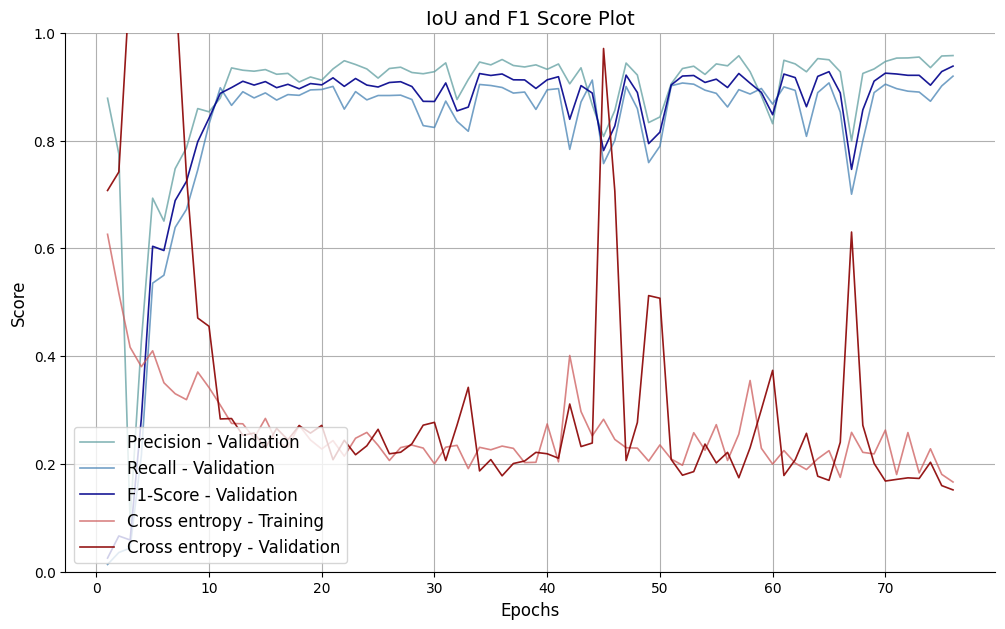

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))
# IoU (same behaviour as F1)
#ax.plot((train_logs_df.index+1).tolist(), train_logs_df.iou_score.tolist(), lw=1.2, color='indianred', alpha=0.75, label = 'IoU - Training')
#ax.plot((train_logs_df.index+1).tolist(), valid_logs_df.iou_score.tolist(), lw=1.5, color='darkred', alpha=0.9, label = 'IoU - Validation')
# precision
ax.plot((train_logs_df.index+1).tolist(), valid_logs_df.precision.tolist(), lw=1.2,  color='cadetblue', alpha=0.75, label = 'Precision - Validation')
# recall
ax.plot((train_logs_df.index+1).tolist(), valid_logs_df.recall.tolist(), lw=1.2,  color='steelblue', alpha=0.75, label = 'Recall - Validation')
# f1
ax.plot((train_logs_df.index+1).tolist(), valid_logs_df.fscore.tolist(), lw=1.2,  color='darkblue', alpha=0.9, label = 'F1-Score - Validation')
# binary cross entropy
ax.plot((train_logs_df.index+1).tolist(), train_logs_df.cross_entropy_loss.tolist(), lw=1.2,  color='indianred', alpha=0.75, label = 'Cross entropy - Training')
ax.plot((train_logs_df.index+1).tolist(), valid_logs_df.cross_entropy_loss.tolist(), lw=1.2,  color='darkred', alpha=0.9, label = 'Cross entropy - Validation')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('IoU and F1 Score Plot', fontsize=14)
plt.ylim([0, 1])
ax.legend(loc='lower left', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.grid()
plt.show()

---

##Prediction

**Check what the untransformed input data looks like**

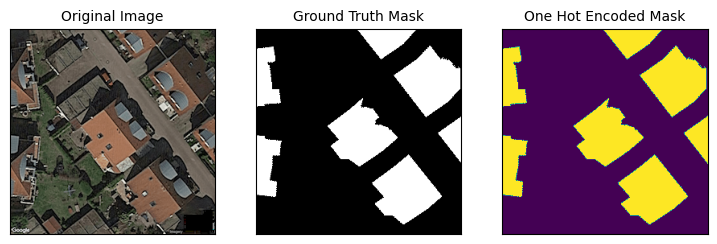

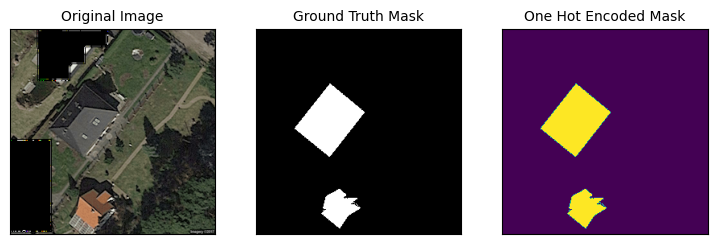

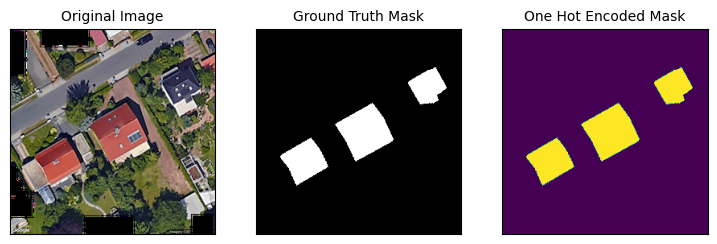

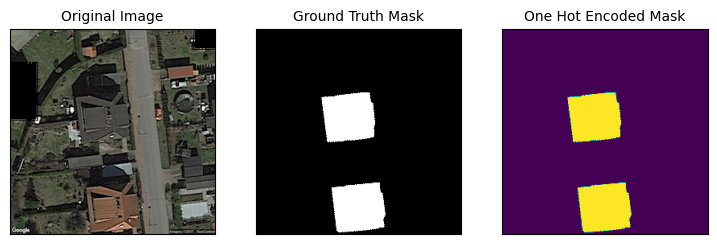

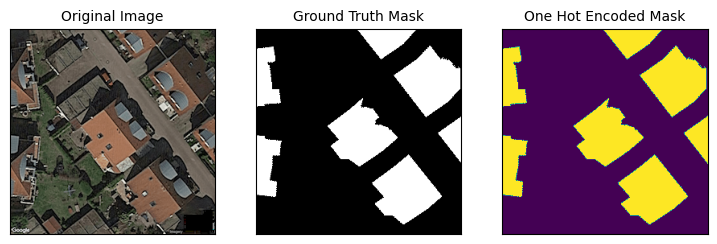

In [75]:
# create dataloader to be used for prediction, i.e. no transformations like for training samples (however, with preprocessing operation: to_tensor(...))
valid_dataset = roofDataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=standardize),
    class_rgb_values=class_rgb_values,
)
valid_dataloader = DataLoader(valid_dataset)

# the same for for visualization (without preprocessing transformations, i.e. as image)
valid_dataset_vis = roofDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing_vis(preprocessing_fn=standardize),
    class_rgb_values=class_rgb_values,
)

for jj in range(5):
  random_idx = random.randint(0, len(valid_dataset_vis)-1)
  image, mask = valid_dataset_vis[random_idx]

  plot_row(
      original_image = image,
      ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
      one_hot_encoded_mask = reverse_one_hot(mask)
  )

---

**Predict the validation set images**

In [ ]:
# predict validation set
for idx in range(len(valid_dataset)):
    image, gt_mask = valid_dataset[idx]
    image_vis = crop_image(valid_dataset_vis[idx][0].astype(np.uint8))
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)

    # Predict test image
    pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))

    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,class_names.index('roof')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values))

    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), class_rgb_values))

    plot_row(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

In [76]:
valid_logs = valid_epoch.run(valid_dataloader)
print("Evaluation on validation Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.2f}")
print(f"Mean Binary Crossentropy: {valid_logs['cross_entropy_loss']:.2f}")
print(f"Mean F1-Score: {valid_logs['fscore']:.2f}")
print(f"Mean precision: {valid_logs['precision']:.2f}")
print(f"Mean recall: {valid_logs['recall']:.2f}")

valid: 100%|██████████| 18/18 [00:00<00:00, 21.32it/s, cross_entropy_loss - 0.1518, iou_score - 0.8846, fscore - 0.9381, precision - 0.9576, recall - 0.9194]
Evaluation on validation Data: 
Mean IoU Score: 0.88
Mean Binary Crossentropy: 0.15
Mean F1-Score: 0.94
Mean precision: 0.96
Mean recall: 0.92


---

**Predict on the test set**


Image: 537.png


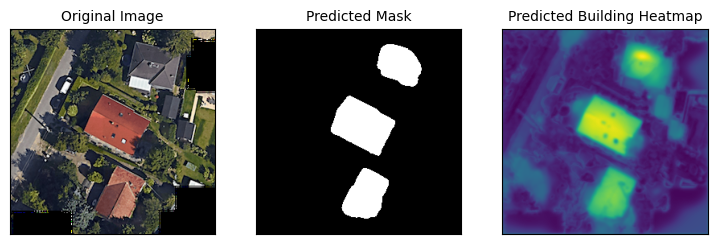


Image: 535.png


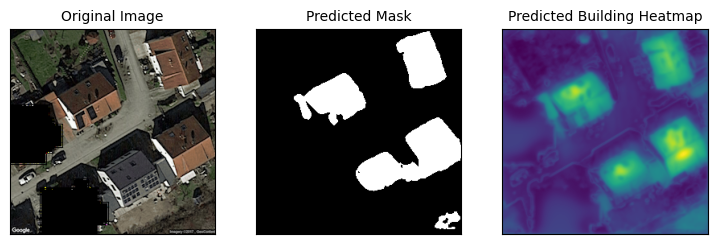


Image: 539.png


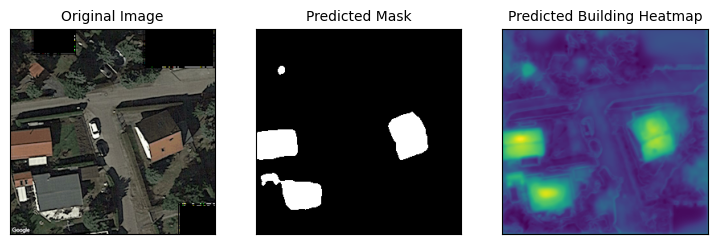


Image: 551.png


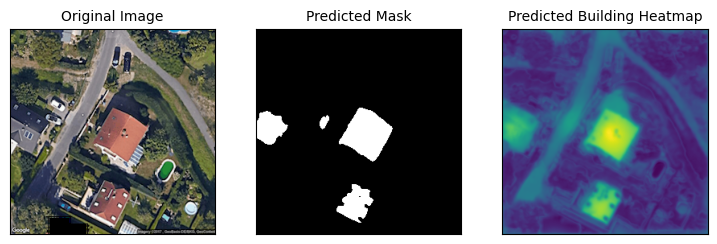


Image: 553.png


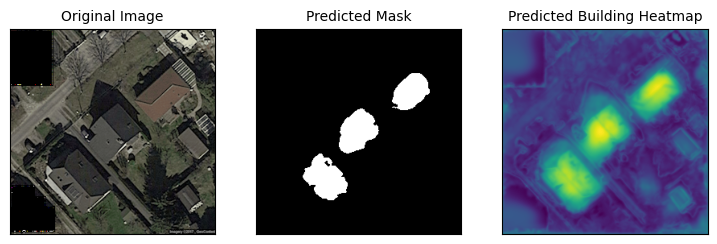

In [29]:
# predict test images

test_names = os.listdir(f'{data_dir}/test/images')
for test_name in test_names:

  print('\nImage:', test_name)
  test_path = f'{data_dir}/test/images/{test_name}'
  image = np.array(Image.open(test_path).convert('RGB'), dtype=np.uint8)

  image_vis = crop_image(image)
  x_tensor = torch.from_numpy(np.transpose(image, axes=(2,0,1))).float().to(device).unsqueeze(0)

  # Predict test image
  pred_mask = model(x_tensor)
  pred_mask = pred_mask.detach().squeeze().cpu().numpy()

  # Convert pred_mask from `CHW` format to `HWC` format
  pred_mask = np.transpose(pred_mask,(1,2,0))

  # Get prediction channel corresponding to building
  pred_building_heatmap = pred_mask[:,:,class_names.index('roof')]
  pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values))

  Image.fromarray(np.hstack([Image.fromarray(np.array(image_vis, dtype=np.uint8)),
                             Image.fromarray(np.array(pred_mask, dtype=np.uint8))])[:,:,::-1]).save(f'{pred_dir}/{test_name}')

  plot_row(
      original_image = image_vis,
      predicted_mask = pred_mask,
      predicted_building_heatmap = pred_building_heatmap
  )


Image: 537.png


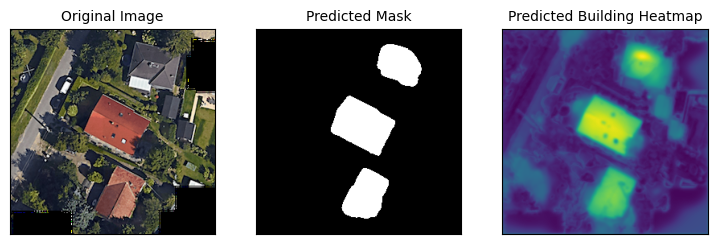


Image: 535.png


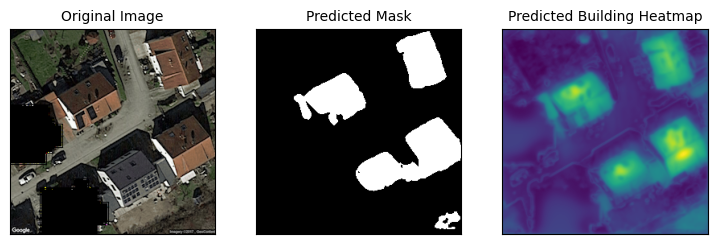


Image: 539.png


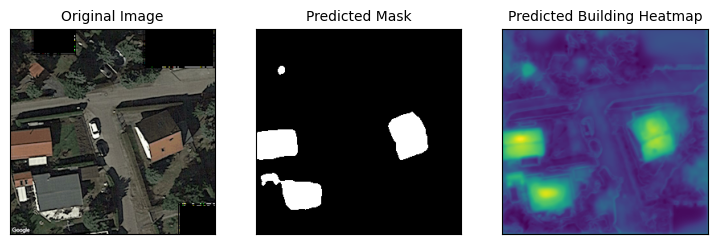


Image: 551.png


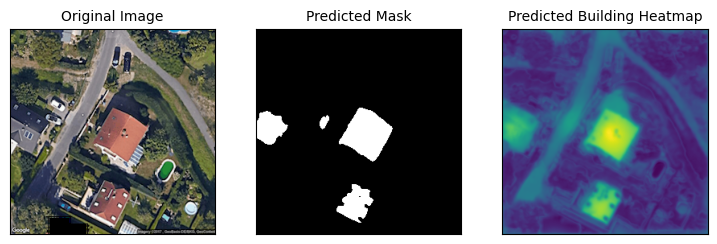


Image: 553.png


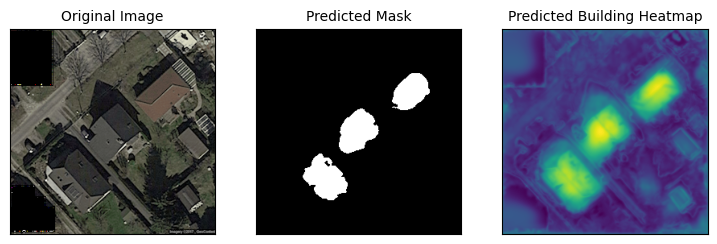

In [77]:
# predict test images

test_names = os.listdir(f'{data_dir}/test/images')
for test_name in test_names:

  print('\nImage:', test_name)
  test_path = f'{data_dir}/test/images/{test_name}'
  image = np.array(Image.open(test_path).convert('RGB'), dtype=np.uint8)

  image_vis = crop_image(image)
  x_tensor = torch.from_numpy(np.transpose(image, axes=(2,0,1))).float().to(device).unsqueeze(0)

  # Predict test image
  pred_mask = model(x_tensor)
  pred_mask = pred_mask.detach().squeeze().cpu().numpy()

  # Convert pred_mask from `CHW` format to `HWC` format
  pred_mask = np.transpose(pred_mask,(1,2,0))

  # Get prediction channel corresponding to building
  pred_building_heatmap = pred_mask[:,:,class_names.index('roof')]
  pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values))

  cv2.imwrite(os.path.join(pred_dir, f'sample_pred_{idx}.png'), np.hstack([image_vis, pred_mask])[:,:,::-1])

  plot_row(
      original_image = image_vis,
      predicted_mask = pred_mask,
      predicted_building_heatmap = pred_building_heatmap
  )